![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Building a Predictive Model for Housing Sales
## Using Linear Regression for Mom & Pop Realty

## Overview and Business Problem

For the second phase of Flatiron's Live Data Science program we were tasked with developing a multiple linear regression model. This model would predict the price of houses in King County, Washington using data from the King County reality dataset. We decided to develop this model for a small realty business named "Mom and Pop Reality". The goal is to provide an accurate prediction for the price of their client's home before puttting it on the market. Client's will always want to get the most money for their home possible. However, realty firms will quickly find themselves with a poor reputation and out of business if a they are misleading or dishonest in their assessed target price. Assuming the firm is acting on good faith and want to provide an accurate assessment, their prediction model must be flexible to the market to continue being competitive in the market place. <br><br>
With these concerns in mind, we set out to explore the features in the data set to design our model, explore correlations between different features and the sale price of the home, and use the features with strong correlations to develop a model to achieve our goal. We made sure to normalize our data using a log transformation and scale our data for consistent analysis. As we concluded our analysis, we discovered the most important features to predicting sale price was the size of the home and lot, the condition and grade of the home, and whether there's a basement. We recommend Mom & Pop Realty take these features into consideration when assessing the values of client's homes. 

## Data Understanding

This dataset contains house sale prices for King County,Washington. It includes homes sold between May 2014 and May 2015. The data was gathered from King County GIS Open Data. The data represents different features of homes in King County. The data is widely varied, as is to be expected. The data states when the house was built and if it was renovated as well as the date of sale. The data includes counts on floors, bathrooms and bedrooms. Also included in grade and condition of the home. The data also includes waterfront property designation and data on view on different landmarks from the property. The data inlcudes information on basement, living and lot area. The data also includes information regarding living and lot area of the closest 15 properties. Additionally, there is also locational data including zip code and latitude and longitudinal of the property. 

Given these features, the target variable will be the sale price of the home, as the goal is to build a model to predict price. We selected features related to the house as the important predictor features. These include continuous data such as the home and lot size, ordinal data such as the number of bedrooms and bathrooms, and categorical data such as the grade and condition of the homes.

In [502]:
# import relevant libraries
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

## Exploring the data

In [503]:
#what data types are in the data?
data = pd.read_csv('data/kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [504]:
# looking for any null values in the data.
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [505]:
#dropping duplicates from the data set based on their id value.
data.drop_duplicates(subset='id', inplace=True)

In [506]:
# 'sqft_basement' is an object type?
# exploring the area of basements
data['sqft_basement'].value_counts()

0.0       12717
?           452
600.0       216
500.0       206
700.0       205
          ...  
2610.0        1
225.0         1
2190.0        1
417.0         1
2360.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [507]:
# '?' is a strange value, we'll make that 0
data.loc[data['sqft_basement'] == '?','sqft_basement'] = 0.0

In [508]:
# orginally this data was stored as text (object), 
# we transform the data type to float to use later for anaylsis
# check to ensure the "?" is now 0.0
data['sqft_basement'] = data['sqft_basement'].map(float)

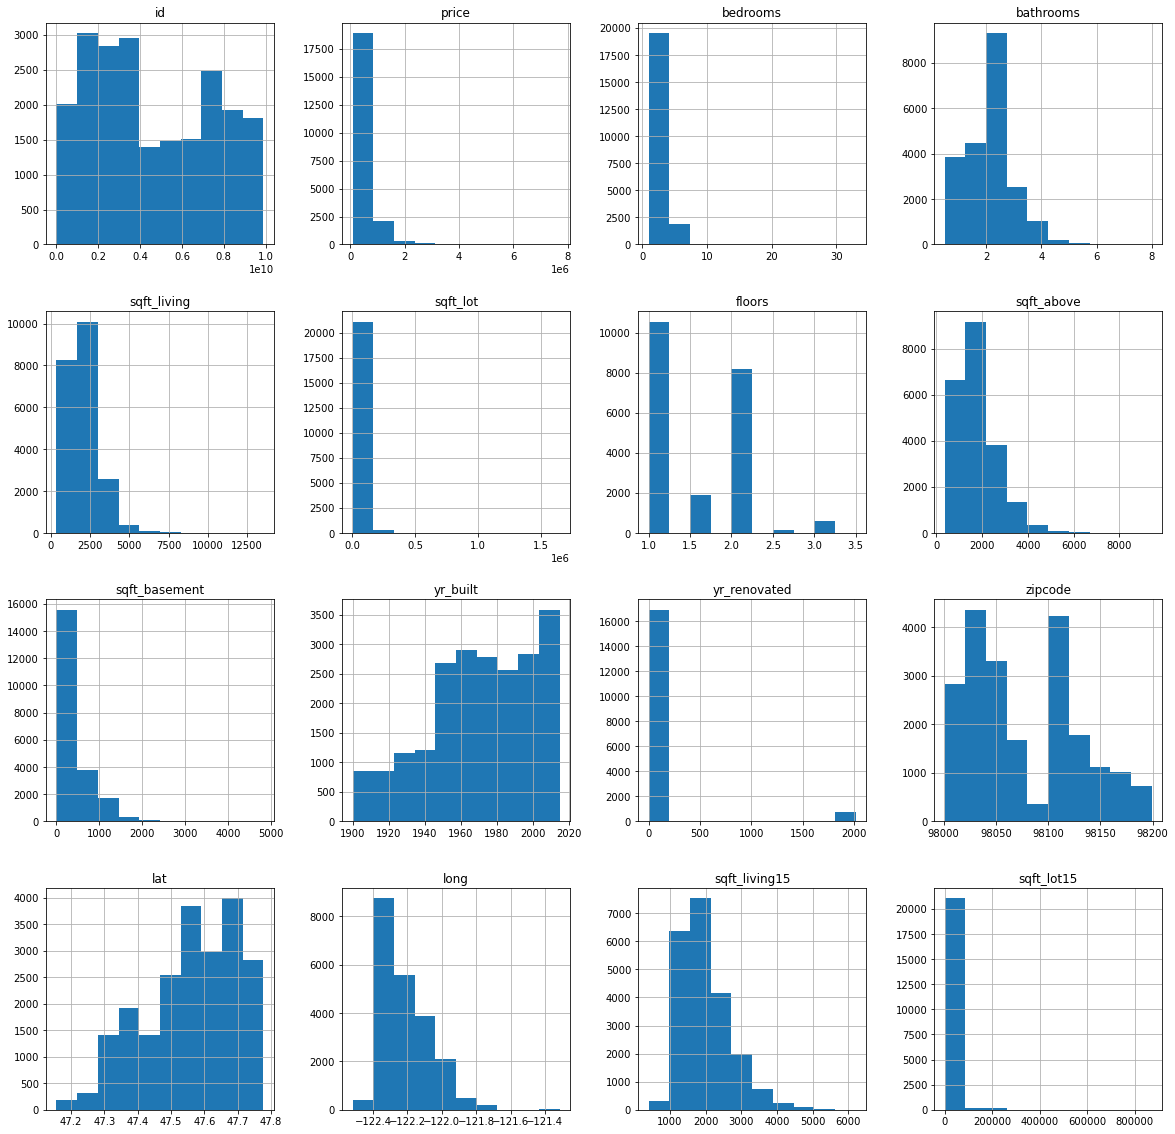

In [509]:
#exploring the distribution of the features
data.hist(figsize=(20,20));

Some of these features look like they could use some log processing. Running a log transformation will help normalize the data for better regression analysis down the line.

In [510]:
#running the log transformation. creates a new data frame.
datalog = pd.DataFrame()
log_cols = ['id','price','sqft_living','sqft_lot','sqft_above', 'sqft_basement']
for col in log_cols:
    if col == 'id':
        datalog[col] = data[col]
        continue
    datalog[f'{col}_log'] = data[col].map(lambda x: np.log(x))

In [511]:
#merges the orginal and new dataframe
data = pd.merge(data,datalog,on='id')

In [512]:
#checking the columns to ensure all data is collected.
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_basement_log'],
      dtype='object')

## Choice of included features

Since there were so many available predictors, we decided to take a subset of them. We based this decision on a desire to make the model predictive only on the features of the house itself, and not so much the location information. Furthermore, we did some initial exploration with location information, but it didn't really go anywhere so we scrapped the idea. See the notebook in 'notebooks/Dave/King_County_Map.ipynb'.

Firstly, because the price is so skewed, we wanted to use log(price) as our output variable, since it will be more normally distributed and thus will follow the assumptions of linear regression a bit better (residuals will be more normal as well). For downstream understanding purposes, we kept the original 'price' as well.

Secondly, we looked at 'grade', 'condition', 'view', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 'bedrooms', 'bathrooms', and 'floors' as potentially important predictors of price.


In [513]:
#reducing our features to consider for analyzation
rel_cols = ['price','price_log', 'grade', 'condition', 'view', 'sqft_living_log',
            'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 
            'bedrooms', 'bathrooms', 'floors','sqft_living',
            'sqft_lot', 'sqft_above']
data = data[rel_cols]

## Data cleaning

In this section we will transform and remove some feature to make the data easier to analyze.

In [514]:
#looking at some statistical information of the numerical dataframe columms
data.describe()

,price,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_basement_log,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above
count,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000
mean,5.407393e+05,13.048915,7.552148,8.989676,7.396578,-inf,3.373950,2.118429,1.495985,2083.132633,1.512804e+04,1791.170215
std,3.679311e+05,0.526726,0.424047,0.903854,0.427241,NaN,0.925405,0.768720,0.540081,918.808412,4.153080e+04,828.692965
min,7.800000e+04,11.264464,5.913503,6.253829,5.913503,-inf,1.000000,0.500000,1.000000,370.000000,5.200000e+02,370.000000
25%,3.225000e+05,12.683858,7.265430,8.525161,7.090077,-inf,3.000000,1.750000,1.000000,1430.000000,5.040000e+03,1200.000000
50%,4.500000e+05,13.017003,7.560080,8.937744,7.352441,-inf,3.000000,2.250000,1.500000,1920.000000,7.614000e+03,1560.000000
75%,6.450000e+05,13.377006,7.843849,9.277111,7.705262,6.309918e+00,4.000000,2.500000,2.000000,2550.000000,1.069050e+04,2220.000000
max,7.700000e+06,15.856731,9.513404,14.317109,9.149528,8.480529e+00,33.000000,8.000000,3.500000,13540.000000,1.651359e+06,9410.000000


In [515]:
# looking at the top 15 properties according to each feature
for col in data.columns:
    print(f'\n{col}:\n')
    print(data.sort_values(by=col,ascending=False).head(15))


price:

           price  price_log         grade condition       view  \
7187   7700000.0  15.856731    13 Mansion      Good       GOOD   
3877   7060000.0  15.769956  11 Excellent   Average    AVERAGE   
9170   6890000.0  15.745582    13 Mansion   Average  EXCELLENT   
4371   5570000.0  15.532906    13 Mansion   Average       NONE   
1434   5350000.0  15.492607     12 Luxury   Average  EXCELLENT   
1301   5300000.0  15.483217     12 Luxury      Good        NaN   
1152   5110000.0  15.446710     12 Luxury   Average  EXCELLENT   
8023   4670000.0  15.356670     12 Luxury   Average  EXCELLENT   
2601   4500000.0  15.319588     12 Luxury   Average  EXCELLENT   
8560   4490000.0  15.317363     12 Luxury   Average       NONE   
12249  4210000.0  15.252973     12 Luxury   Average       NONE   
4110   4000000.0  15.201805     12 Luxury   Average       NONE   
2066   3850000.0  15.163584  11 Excellent      Good  EXCELLENT   
6972   3800000.0  15.150512    13 Mansion      Good    AVERAGE   
1

           price  price_log         grade  condition       view  \
12651  2280000.0  14.639686     12 Luxury    Average  EXCELLENT   
7187   7700000.0  15.856731    13 Mansion       Good       GOOD   
3877   7060000.0  15.769956  11 Excellent    Average    AVERAGE   
9170   6890000.0  15.745582    13 Mansion    Average  EXCELLENT   
8023   4670000.0  15.356670     12 Luxury    Average  EXCELLENT   
4371   5570000.0  15.532906    13 Mansion    Average       NONE   
14413  2890000.0  14.876767    13 Mansion    Average  EXCELLENT   
18125  3300000.0  15.009433  11 Excellent    Average       NONE   
1152   5110000.0  15.446710     12 Luxury    Average  EXCELLENT   
1434   5350000.0  15.492607     12 Luxury    Average  EXCELLENT   
13279  2420000.0  14.699278    13 Mansion    Average    AVERAGE   
19671  2700000.0  14.808762     12 Luxury    Average       NONE   
16610  1920000.0  14.467836     12 Luxury    Average       NONE   
18299  3300000.0  15.009433     12 Luxury  Very Good       NON

           price  price_log         grade  condition       view  \
8023   4670000.0  15.356670     12 Luxury    Average  EXCELLENT   
12651  2280000.0  14.639686     12 Luxury    Average  EXCELLENT   
15327  3200000.0  14.978661     12 Luxury       Good  EXCELLENT   
7187   7700000.0  15.856731    13 Mansion       Good       GOOD   
9989   1900000.0  14.457364  11 Excellent       Good       GOOD   
4371   5570000.0  15.532906    13 Mansion    Average       NONE   
5006   1390000.0  14.144814  10 Very Good       Good  EXCELLENT   
21152  1490000.0  14.214287     12 Luxury    Average       GOOD   
6972   3800000.0  15.150512    13 Mansion       Good    AVERAGE   
6570    850000.0  13.652992      9 Better       Fair       NONE   
14901  1540000.0  14.247293      9 Better  Very Good       GOOD   
2687   1110000.0  13.919871  11 Excellent    Average  EXCELLENT   
11714  1790000.0  14.397726     12 Luxury    Average  EXCELLENT   
2069   1200000.0  13.997832  11 Excellent    Average       NON

           price  price_log         grade  condition       view  \
12651  2280000.0  14.639686     12 Luxury    Average  EXCELLENT   
7187   7700000.0  15.856731    13 Mansion       Good       GOOD   
3877   7060000.0  15.769956  11 Excellent    Average    AVERAGE   
9170   6890000.0  15.745582    13 Mansion    Average  EXCELLENT   
8023   4670000.0  15.356670     12 Luxury    Average  EXCELLENT   
4371   5570000.0  15.532906    13 Mansion    Average       NONE   
14413  2890000.0  14.876767    13 Mansion    Average  EXCELLENT   
18125  3300000.0  15.009433  11 Excellent    Average       NONE   
1152   5110000.0  15.446710     12 Luxury    Average  EXCELLENT   
1434   5350000.0  15.492607     12 Luxury    Average  EXCELLENT   
13279  2420000.0  14.699278    13 Mansion    Average    AVERAGE   
19671  2700000.0  14.808762     12 Luxury    Average       NONE   
16610  1920000.0  14.467836     12 Luxury    Average       NONE   
18299  3300000.0  15.009433     12 Luxury  Very Good       NON

33 bedrooms is pretty crazy and not highly correlated with a high price. Based on the data, we are unsure if this data is a typo or an honest outlier. We decided to drop this property.

In [516]:
data = data[data['bedrooms'] != 33]

In [517]:
# looking at the value counts for view we see none composes 89.8% of the column.
data['view'].value_counts()

NONE         19252
AVERAGE        956
GOOD           505
FAIR           329
EXCELLENT      314
Name: view, dtype: int64

In [518]:
data['view'].value_counts()[0]/len(data)

0.8988281432373126

In [519]:
# delete 'view' column since not much information given
data.drop(columns='view', inplace=True)

In [521]:
data

,price,price_log,grade,condition,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_basement_log,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above
0,221900.0,12.309982,7 Average,Average,7.073270,8.639411,7.073270,-inf,3,1.00,1.0,1180,5650,1180
1,538000.0,13.195614,7 Average,Average,7.851661,8.887653,7.682482,5.991465,3,2.25,2.0,2570,7242,2170
2,180000.0,12.100712,6 Low Average,Average,6.646391,9.210340,6.646391,-inf,2,1.00,1.0,770,10000,770
3,604000.0,13.311329,7 Average,Very Good,7.580700,8.517193,6.956545,6.813445,4,3.00,1.0,1960,5000,1050
4,510000.0,13.142166,8 Good,Average,7.426549,8.997147,7.426549,-inf,3,2.00,1.0,1680,8080,1680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,360000.0,12.793859,8 Good,Average,7.333023,7.030857,7.333023,-inf,3,2.50,3.0,1530,1131,1530
21416,400000.0,12.899220,8 Good,Average,7.745003,8.667852,7.745003,-inf,4,2.50,2.0,2310,5813,2310
21417,402101.0,12.904459,7 Average,Average,6.927558,7.207860,6.927558,-inf,2,0.75,2.0,1020,1350,1020
21418,400000.0,12.899220,8 Good,Average,7.377759,7.778211,7.377759,-inf,3,2.50,2.0,1600,2388,1600


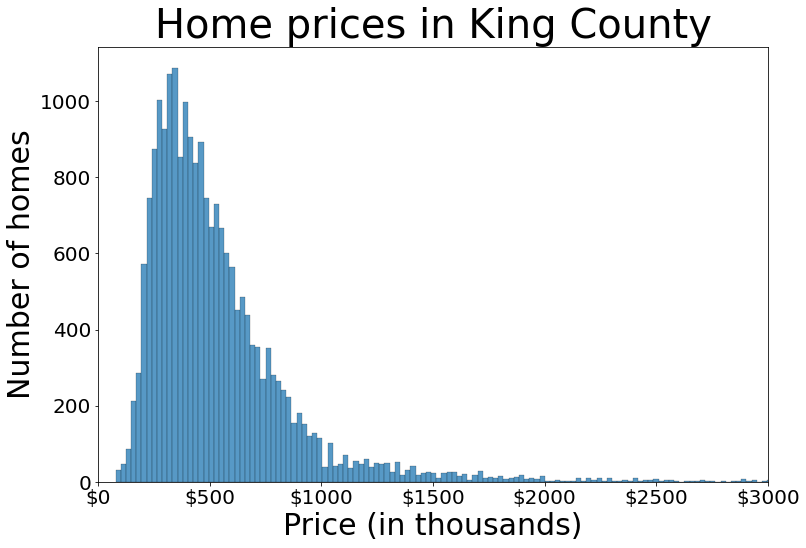

In [553]:
#here we have the new distribution of home prices in the data set
fig, ax = plt.subplots(figsize= (12,8))
ax = sns.histplot(data["price"]/1000)

ax.set_title("Home prices in King County",fontsize=40)
ax.set_xlabel("Price (in thousands)",fontsize=30)
ax.set_ylabel("Number of homes",fontsize=30)
ax.tick_params(labelsize=20)
ax.set_xlim([0,3000])
ax.xaxis.set_major_formatter('${x:1.0f}')
plt.savefig("images/House_prices.png")

In [446]:
# median house sale price
data['price'].median()

450000.0

## Transforming categorical data
#### 'Grade' to 4 categories: Low, Average, Above Average, and Excellent

In [525]:
# Lows including 3 Poor, 5 Fair and 6 Low Average
data['grade'].replace('3 Poor','Low Grade', inplace=True)
data['grade'].replace('5 Fair','Low Grade', inplace=True)
data['grade'].replace('4 Low','Low Grade', inplace=True)
data['grade'].replace('6 Low Average','Low Grade', inplace=True)

# Average including 7 Average 
data['grade'].replace('7 Average','Average Grade', inplace=True)

# Average Above including 8 Good,9 Better
data['grade'].replace('8 Good','Above Average Grade', inplace=True)
data['grade'].replace('9 Better','Above Average Grade', inplace=True)

# Excellent including 10 Very Good, 11 Excellent,12 Luxury and 13 Mansion
data['grade'].replace('10 Very Good','Excellent Grade', inplace=True)
data['grade'].replace('11 Excellent','Excellent Grade', inplace=True)
data['grade'].replace('12 Luxury','Excellent Grade', inplace=True)
data['grade'].replace('13 Mansion','Excellent Grade', inplace=True)

In [526]:
#feature breakdown
data['grade'].value_counts(normalize=True)

Average Grade          0.414959
Above Average Grade    0.403707
Low Grade              0.105374
Excellent Grade        0.075961
Name: grade, dtype: float64

#### 'Condition' to only 2 categories: Low-Average, and Good

In [527]:
#looking at feature breakdown to decide how to transform the data
data['condition'].value_counts(normalize=True)

Average      0.648957
Good         0.263458
Very Good    0.078715
Fair         0.007563
Poor         0.001307
Name: condition, dtype: float64

In [528]:
# Low-Average including Poor, Fair, Average
data['condition'].replace('Poor','Low-Average Condition', inplace=True)
data['condition'].replace('Fair','Low-Average Condition', inplace=True)
data['condition'].replace('Average','Low-Average Condition', inplace=True)

# Good including Good and Very Good
data['condition'].replace('Good','Good Condition', inplace=True)
data['condition'].replace('Very Good','Good Condition', inplace=True)

#data is better distribued when grouped
data['condition'].value_counts(normalize=True)

Low-Average Condition    0.657827
Good Condition           0.342173
Name: condition, dtype: float64

In [529]:
#exploring the means and counts for grades per condition
data.groupby(by=['condition','grade']).agg(['mean','count'])['price_log']

mean  count
condition             grade                                
Good Condition        Above Average Grade  13.363536   2348
                      Average Grade        12.892650   3638
                      Excellent Grade      14.129108    293
                      Low Grade            12.565022   1050
Low-Average Condition Above Average Grade  13.196417   6299
                      Average Grade        12.795591   5250
                      Excellent Grade      13.888133   1334
                      Low Grade            12.470903   1207

In [530]:
#exploring the means and counts for grades per condition
data.groupby(by=['grade','condition']).agg(['mean','count'])['price']

mean  count
grade               condition                                 
Above Average Grade Good Condition         6.992132e+05   2348
                    Low-Average Condition  5.800036e+05   6299
Average Grade       Good Condition         4.278913e+05   3638
                    Low-Average Condition  3.840939e+05   5250
Excellent Grade     Good Condition         1.544270e+06    293
                    Low-Average Condition  1.196048e+06   1334
Low Grade           Good Condition         3.087356e+05   1050
                    Low-Average Condition  2.829052e+05   1207

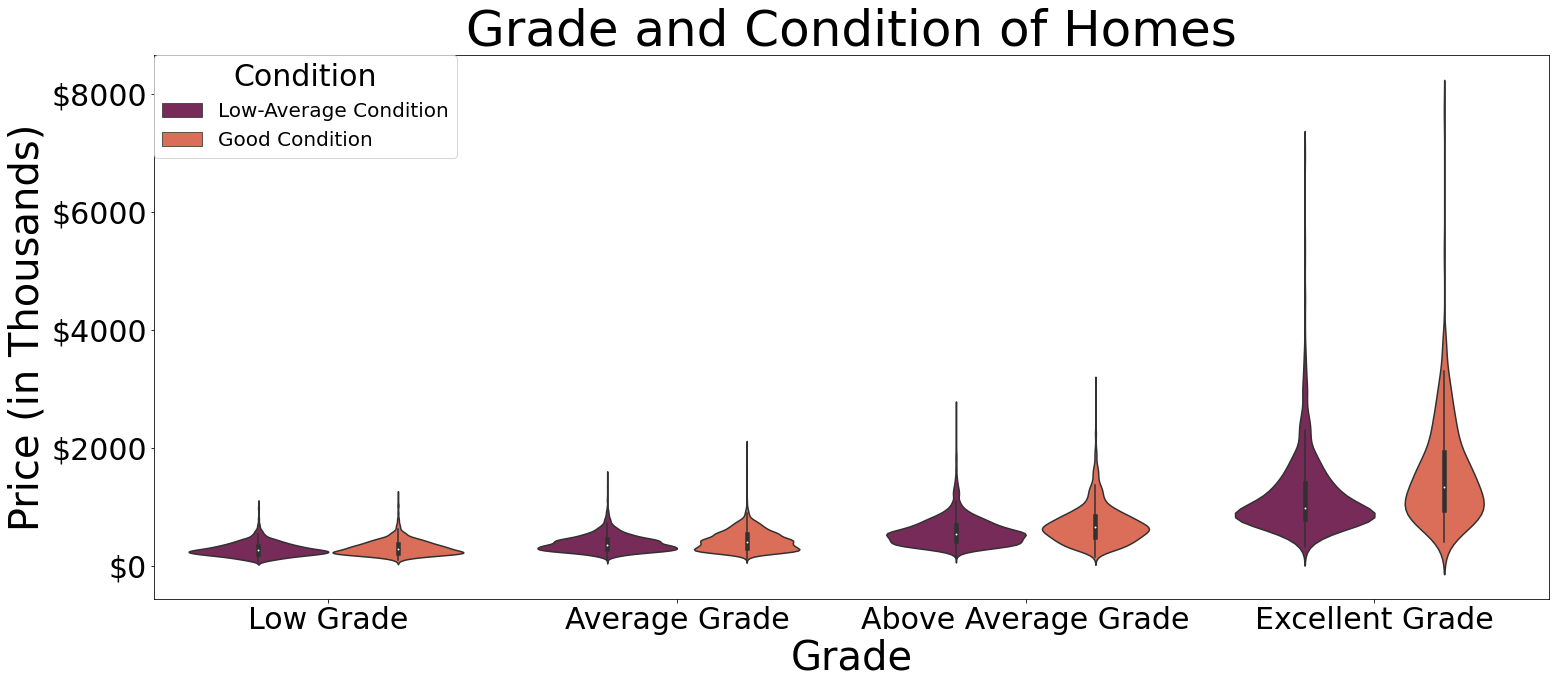

In [531]:
fig,ax = plt.subplots(figsize = (25,10))
sns.violinplot(x='grade',y=(data['price']/1000), hue= "condition", data = data, palette="rocket", 
               order=["Low Grade", "Average Grade", "Above Average Grade", "Excellent Grade"], 
               hue_order = ["Low-Average Condition", "Good Condition"])

ax.set_title("Grade and Condition of Homes",fontsize=50)
ax.set_xlabel("Grade",fontsize=40)
ax.set_ylabel("Price (in Thousands)",fontsize=40)
ax.tick_params(labelsize=30)
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.legend(loc="upper left", borderaxespad=0., title = "Condition",fontsize=20, title_fontsize=30)
plt.savefig('images/Grade_Condition.png')

## Observations of Grad and conditions of Homes
Home price increases as grade improves <br>
Home price increases as condition improves <br>
Home price increases as condition improves within grade

### One-Hot Encoding the categorical data
He break out our categorical featsures (Condition and Grade) into individaul columns using SkLearn's Onehotencoding function and drop the first column to avoid multicollinearity issues

In [532]:
cond = data[["condition"]]
ohe = OneHotEncoder(categories="auto", handle_unknown="error", sparse=False)
ohe.fit(cond)
cond_encod = ohe.transform(cond)
cond_encod = pd.DataFrame(
    # Pass in NumPy array
    cond_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
cond_encod.drop(columns='Low-Average Condition', inplace=True)

In [533]:
grade = data[["grade"]]
ohe = OneHotEncoder(categories="auto",handle_unknown="ignore", sparse=False)
ohe.fit(grade)
grade_encod = ohe.transform(grade)
grade_encod = pd.DataFrame(
    # Pass in NumPy array
    grade_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
grade_encod.drop(columns='Average Grade', inplace=True)

In [534]:
#drops the orginal columns because the data wee need is now split into columns
data = pd.concat([data, cond_encod, grade_encod], axis=1)\
        .drop(columns=['condition','grade'])

### Changing sqft_basement to a binomial variable "has_basement"

In [535]:
# replace sqft_basement with has_basement: True (1) / False (0)
data['sqft_basement_log'] = data['sqft_basement_log'].map(lambda x: 1 if x > 0 else 0)
data.rename(columns={'sqft_basement_log':'has_basement'}, inplace=True)

In [457]:
#pair plot visually exploring the relationship between the features
sns.pairplot(data)

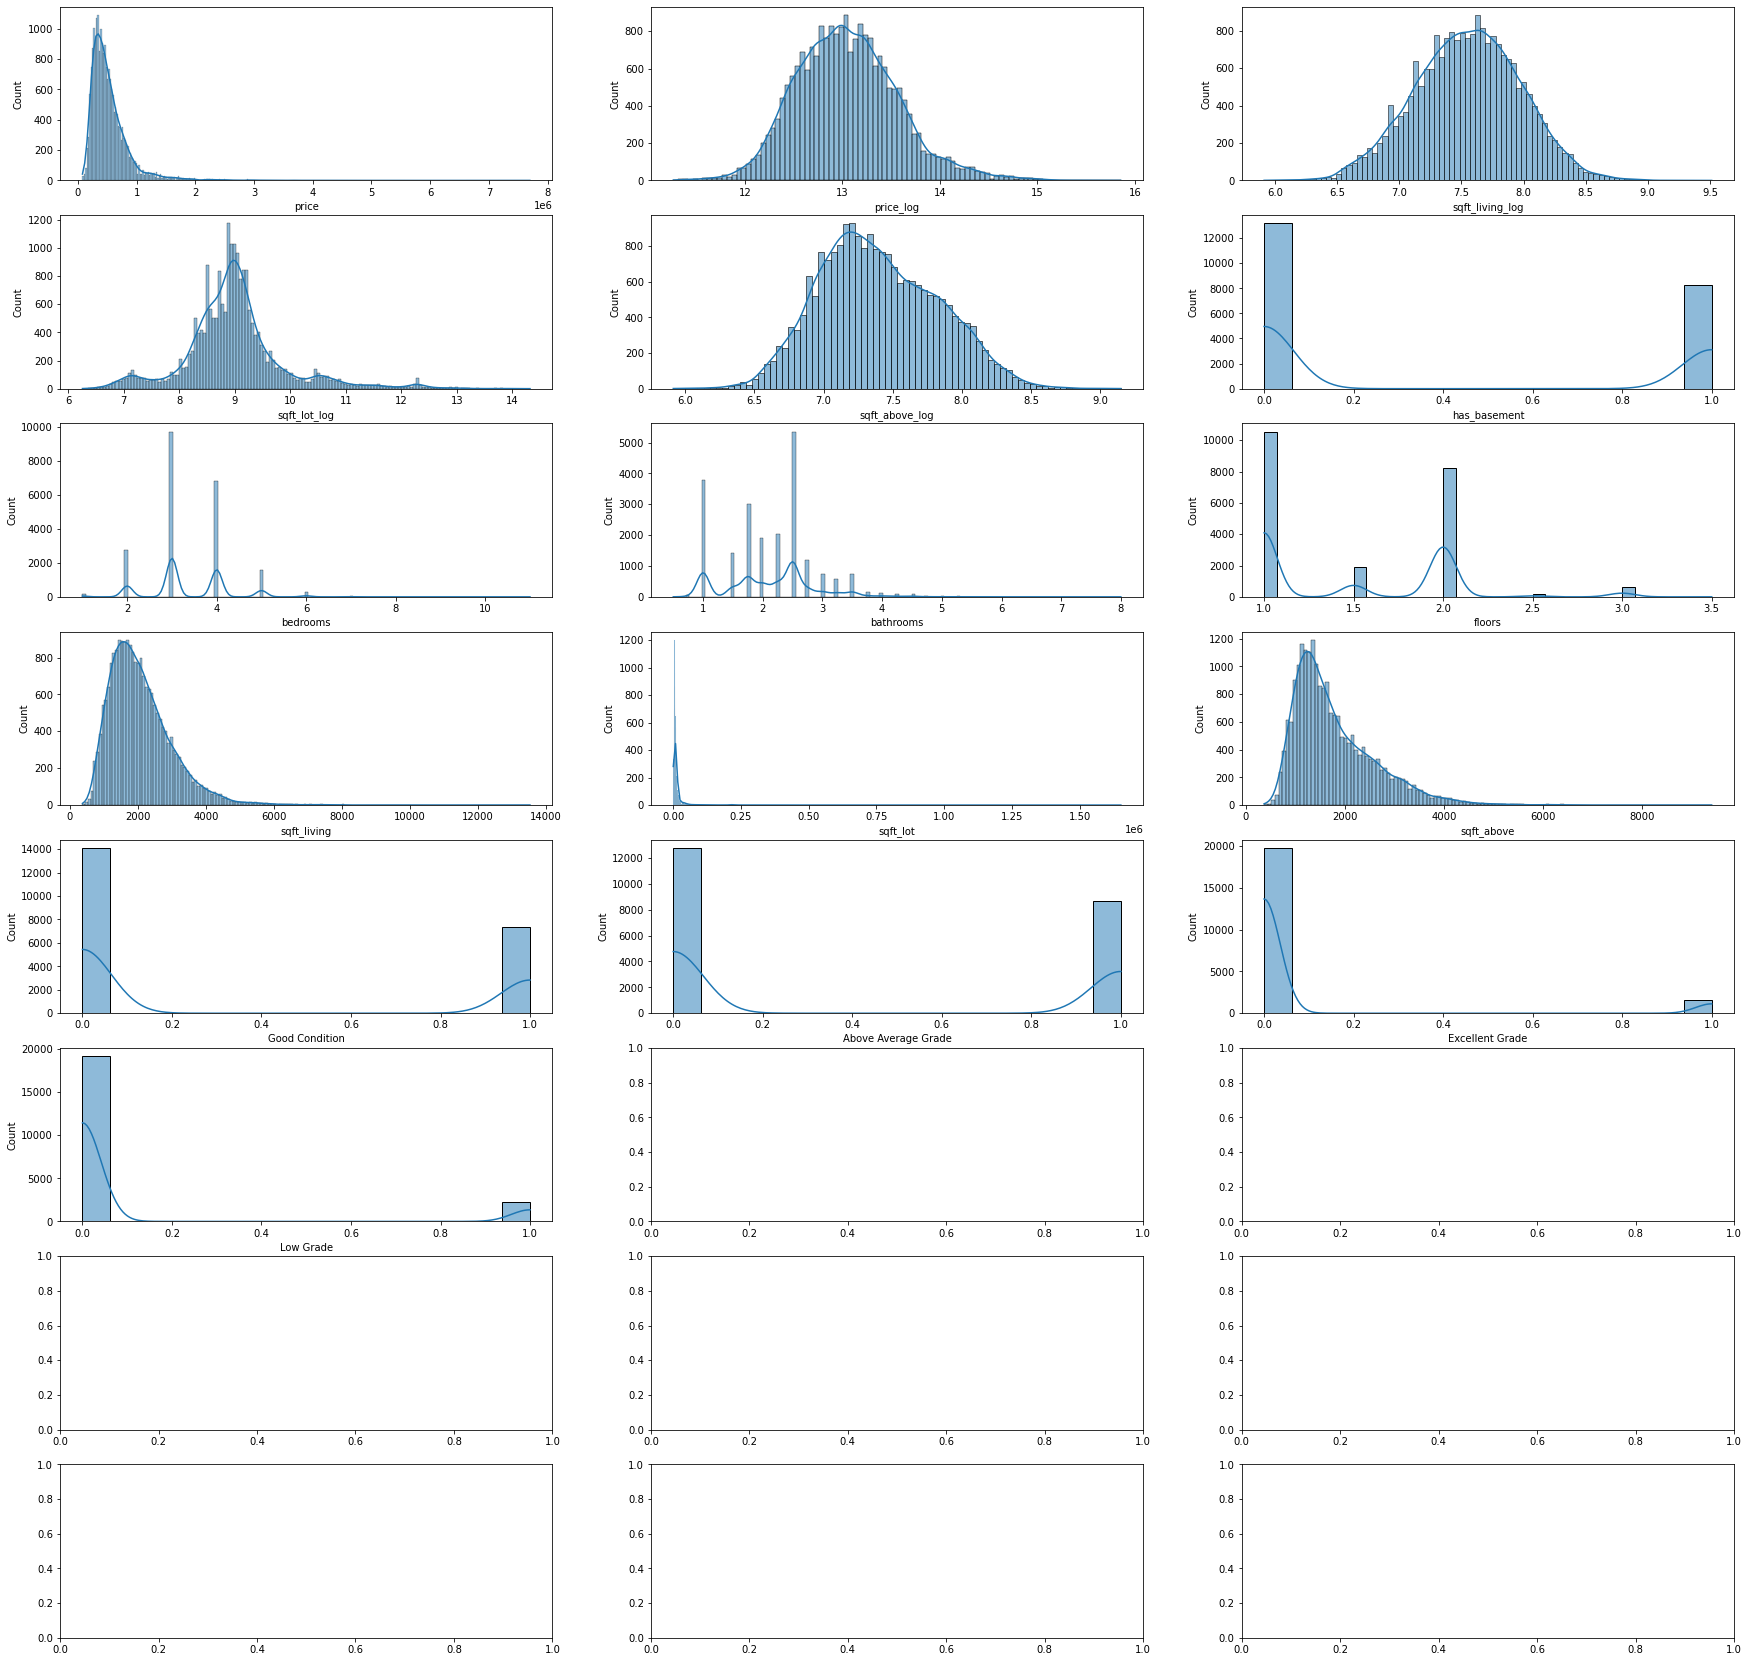

In [458]:
#exploring the distributions of our data
fig, axes = plt.subplots(8,3, figsize=(30,30))
for i, col in enumerate(data.columns):
    sns.histplot(data=data, x=col, kde=True, ax=axes[i//3,i%3]);

In [459]:
#exploring the correlations between the price and features
data.corr()

,price,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,has_basement,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,Good Condition,Above Average Grade,Excellent Grade,Low Grade
price,1.000000,0.891581,0.611742,0.161570,0.542528,0.177584,0.316721,0.526239,0.256303,0.701887,0.089114,0.605318,0.003215,0.160209,0.559528,-0.229289
price_log,0.891581,1.000000,0.674862,0.138580,0.586223,0.207999,0.351601,0.551553,0.310337,0.695280,0.099544,0.601833,-0.003968,0.301334,0.480448,-0.348078
sqft_living_log,0.611742,0.674862,1.000000,0.326818,0.865069,0.232400,0.638490,0.761852,0.366395,0.954597,0.149518,0.832513,-0.082480,0.358277,0.456103,-0.443124
sqft_lot_log,0.161570,0.138580,0.326818,1.000000,0.319225,-0.049190,0.190835,0.100775,-0.238045,0.345079,0.638384,0.332004,0.112276,-0.033424,0.218880,-0.006698
sqft_above_log,0.542528,0.586223,0.865069,0.319225,1.000000,-0.213746,0.531284,0.695399,0.546464,0.843130,0.162934,0.962522,-0.177308,0.364542,0.467770,-0.389313
has_basement,0.177584,0.207999,0.232400,-0.049190,-0.213746,1.000000,0.159616,0.159759,-0.252797,0.200317,-0.035144,-0.207987,0.121345,0.020809,0.009171,-0.123530
bedrooms,0.316721,0.351601,0.638490,0.190835,0.531284,0.159616,1.000000,0.528912,0.183556,0.594217,0.033634,0.493560,0.004518,0.180031,0.198830,-0.280190
bathrooms,0.526239,0.551553,0.761852,0.100775,0.695399,0.159759,0.528912,1.000000,0.501795,0.755519,0.087775,0.686325,-0.176575,0.348835,0.403591,-0.398554
floors,0.256303,0.310337,0.366395,-0.238045,0.546464,-0.252797,0.183556,0.501795,1.000000,0.352856,-0.005571,0.522733,-0.309892,0.345428,0.222205,-0.247907
sqft_living,0.701887,0.695280,0.954597,0.345079,0.843130,0.200317,0.594217,0.755519,0.352856,1.000000,0.172582,0.876534,-0.089670,0.276039,0.558332,-0.343681


In [460]:
data.columns

Index(['price', 'price_log', 'sqft_living_log', 'sqft_lot_log',
       'sqft_above_log', 'has_basement', 'bedrooms', 'bathrooms', 'floors',
       'sqft_living', 'sqft_lot', 'sqft_above', 'Good Condition',
       'Above Average Grade', 'Excellent Grade', 'Low Grade'],
      dtype='object')

In [461]:
#an organized series showing the correlations to price
datacorrp = data[['price_log', 'has_basement', 'bedrooms', 'bathrooms', 'floors',
       'sqft_living', 'sqft_lot', 'sqft_above',
       'Good Condition', 'Above Average Grade', 'Excellent Grade',
       'Low Grade']]
datacorr = datacorrp.corr().sort_values('price_log',ascending=False)['price_log']
datacorr = datacorr.drop(index=['price_log'])
datacorr

sqft_living            0.695280
sqft_above             0.601833
bathrooms              0.551553
Excellent Grade        0.480448
bedrooms               0.351601
floors                 0.310337
Above Average Grade    0.301334
has_basement           0.207999
sqft_lot               0.099544
Good Condition        -0.003968
Low Grade             -0.348078
Name: price_log, dtype: float64

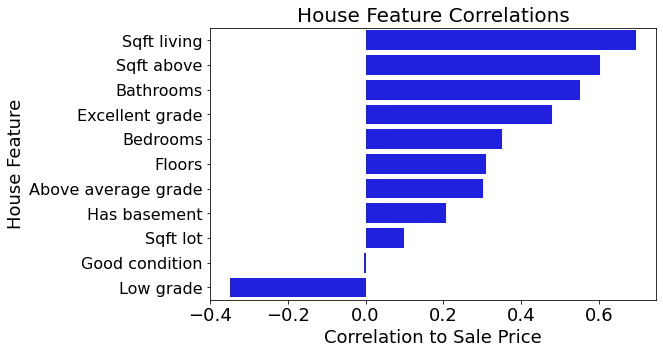

In [462]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=datacorr.values, y=datacorr.index, orient='h', color='b')
ylabels = [item.capitalize() for item in datacorr.index]
ylabels = [item.split('_') for item in ylabels]
ylabels = [' '.join(item) for item in ylabels]
ax.set_yticklabels(ylabels, size=16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.set_xlabel('Correlation to Sale Price', size=18)
ax.set_ylabel('House Feature', size=18)
ax.set_title('House Feature Correlations', size=20)
plt.savefig("images/correlations.png");

In [463]:
#exploring the correlations between features to look for multicollinearity issues
datafeat = data.drop(columns=['price','price_log'])
datafeat.corr()

,sqft_living_log,sqft_lot_log,sqft_above_log,has_basement,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,Good Condition,Above Average Grade,Excellent Grade,Low Grade
sqft_living_log,1.000000,0.326818,0.865069,0.232400,0.638490,0.761852,0.366395,0.954597,0.149518,0.832513,-0.082480,0.358277,0.456103,-0.443124
sqft_lot_log,0.326818,1.000000,0.319225,-0.049190,0.190835,0.100775,-0.238045,0.345079,0.638384,0.332004,0.112276,-0.033424,0.218880,-0.006698
sqft_above_log,0.865069,0.319225,1.000000,-0.213746,0.531284,0.695399,0.546464,0.843130,0.162934,0.962522,-0.177308,0.364542,0.467770,-0.389313
has_basement,0.232400,-0.049190,-0.213746,1.000000,0.159616,0.159759,-0.252797,0.200317,-0.035144,-0.207987,0.121345,0.020809,0.009171,-0.123530
bedrooms,0.638490,0.190835,0.531284,0.159616,1.000000,0.528912,0.183556,0.594217,0.033634,0.493560,0.004518,0.180031,0.198830,-0.280190
bathrooms,0.761852,0.100775,0.695399,0.159759,0.528912,1.000000,0.501795,0.755519,0.087775,0.686325,-0.176575,0.348835,0.403591,-0.398554
floors,0.366395,-0.238045,0.546464,-0.252797,0.183556,0.501795,1.000000,0.352856,-0.005571,0.522733,-0.309892,0.345428,0.222205,-0.247907
sqft_living,0.954597,0.345079,0.843130,0.200317,0.594217,0.755519,0.352856,1.000000,0.172582,0.876534,-0.089670,0.276039,0.558332,-0.343681
sqft_lot,0.149518,0.638384,0.162934,-0.035144,0.033634,0.087775,-0.005571,0.172582,1.000000,0.183204,0.003680,0.010944,0.116317,-0.009450
sqft_above,0.832513,0.332004,0.962522,-0.207987,0.493560,0.686325,0.522733,0.876534,0.183204,1.000000,-0.184618,0.281413,0.557355,-0.307238


In [464]:
# analyzing the high correlated pairs
datafeat = data.drop(columns=['price_log','price'])
dtfc = datafeat.corr().abs().stack().reset_index().sort_values(0, ascending=False)

dtfc['col_pairs'] = list(zip(dtfc.level_0,dtfc.level_1))
dtfc['same'] = dtfc['col_pairs'].map(lambda x: (x[0] in x[1]) or (x[1] in x[0]))
dtfc['col_pairs'] = dtfc['col_pairs'].map(lambda x:sorted(list(x)))
dtfc.set_index(['col_pairs'],inplace=True)
dtfc = dtfc[dtfc['same'] == False]
dtfc.drop(columns=['level_0','level_1','same'],inplace=True)
dtfc.columns = ['C']
dtfc.drop_duplicates(inplace=True)
dtfc.head(20)

,C
col_pairs,
"[sqft_above, sqft_living]",0.876534
"[sqft_above_log, sqft_living_log]",0.865069
"[sqft_above_log, sqft_living]",0.843130
"[sqft_above, sqft_living_log]",0.832513
"[bathrooms, sqft_living_log]",0.761852
"[bathrooms, sqft_living]",0.755519
"[bathrooms, sqft_above_log]",0.695399
"[bathrooms, sqft_above]",0.686325
"[bedrooms, sqft_living_log]",0.638490


## Feature Engineering

Because these is some clear multicollinearity occurring between house features, we decided that one way to get around this was to add features that combined them in logical ways. This would help deal with the dependence of variables on each other, and maybe give some heightened insight into how these variables are important to the sale price.

In [465]:
#bedrooms per sqfoot of living space
data["bedroom/sqft_above_log"] = data["bedrooms"] / data["sqft_above_log"]
#bathrooms per sqfoot of living space 
data["bathrooms/sqft_above_log"] = data["bathrooms"] / data["sqft_above_log"]

## Exploration of data correlations

In [466]:
#checking the column names for our combined data sets
data.columns

Index(['price', 'price_log', 'sqft_living_log', 'sqft_lot_log',
       'sqft_above_log', 'has_basement', 'bedrooms', 'bathrooms', 'floors',
       'sqft_living', 'sqft_lot', 'sqft_above', 'Good Condition',
       'Above Average Grade', 'Excellent Grade', 'Low Grade',
       'bedroom/sqft_above_log', 'bathrooms/sqft_above_log'],
      dtype='object')

## Exploring direct linear regressions on price
We will not explore logged data for clarity and understanding

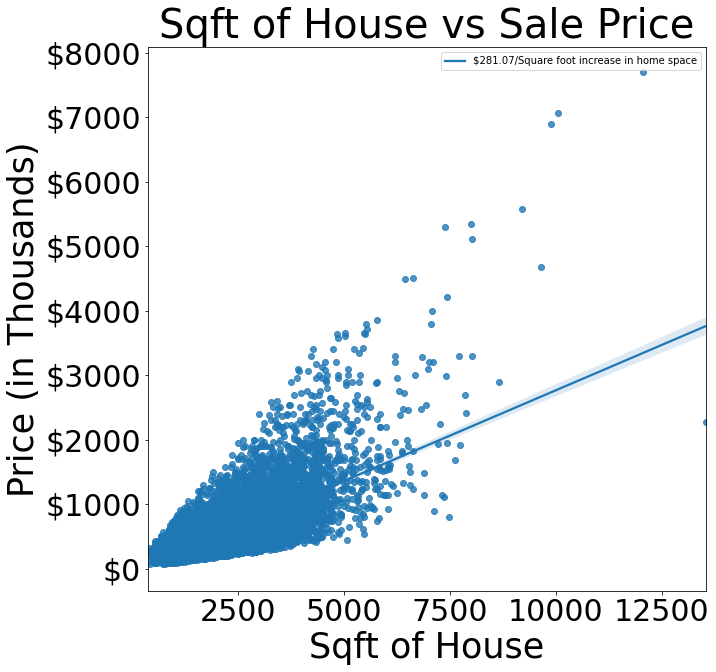

In [537]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data["sqft_living"],data['price'])

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.regplot(x=(data["sqft_living"]), y=(data['price']/1000),
                 line_kws={'label':"${0:.2f}/Square foot increase in home space".format(slope)})
ax.legend()

ax.set_title("Sqft of House vs Sale Price",fontsize=40)
ax.set_xlabel("Sqft of House",fontsize=35)
ax.set_ylabel("Price (in Thousands)",fontsize=35)
ax.tick_params(labelsize=30)
ax.yaxis.set_major_formatter('${x:1.0f}')
plt.savefig("images/sqft_house_v_price.png")

In [539]:
bathtemp = data[['price','bathrooms']]
bathtemp.loc[bathtemp['bathrooms'] <= 1,'bathrooms'] = 1
bathtemp.loc[(bathtemp['bathrooms'] > 1) & (bathtemp['bathrooms'] <= 2),'bathrooms'] = 2
bathtemp.loc[(bathtemp['bathrooms'] > 2) & (bathtemp['bathrooms'] <= 3),'bathrooms'] = 3
bathtemp.loc[(bathtemp['bathrooms'] > 3) & (bathtemp['bathrooms'] <= 4),'bathrooms'] = 4
bathtemp.loc[(bathtemp['bathrooms'] > 4) & (bathtemp['bathrooms'] <= 5),'bathrooms'] = 5
bathtemp.loc[(bathtemp['bathrooms'] > 5) & (bathtemp['bathrooms'] <= 6),'bathrooms'] = 6
bathtemp.loc[(bathtemp['bathrooms'] > 6) & (bathtemp['bathrooms'] <= 7),'bathrooms'] = 7
bathtemp.loc[(bathtemp['bathrooms'] > 7) & (bathtemp['bathrooms'] <= 8),'bathrooms'] = 8

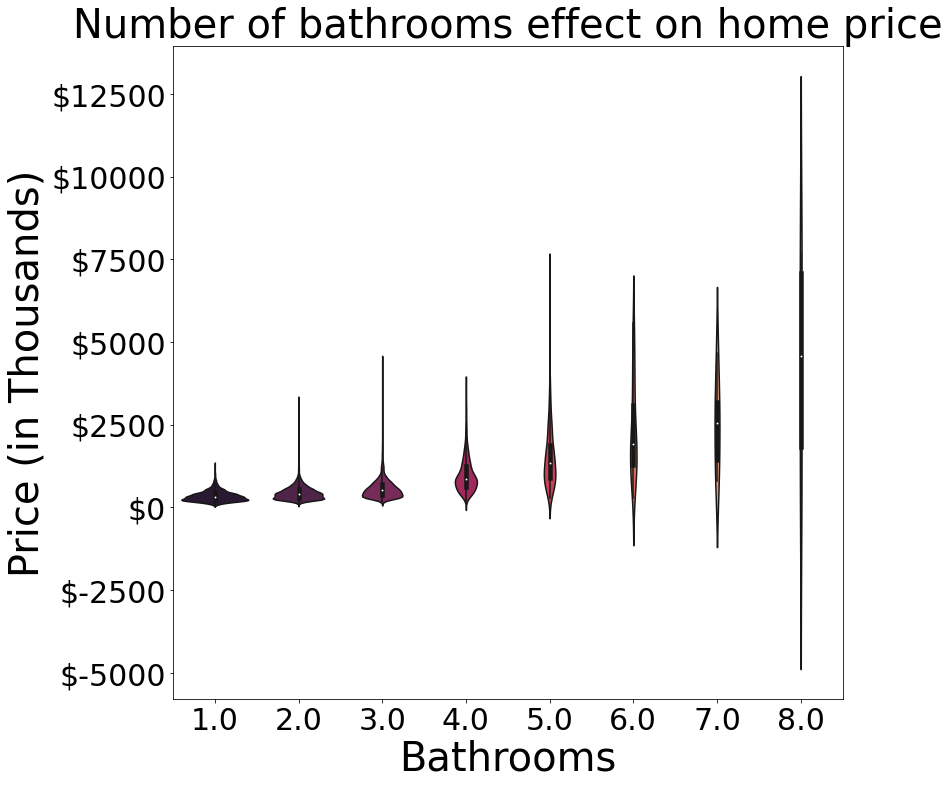

In [544]:
fig,ax = plt.subplots(figsize = (12,12))


sns.violinplot(x=bathtemp['bathrooms'],y=(bathtemp['price']/1000), data = bathtemp, 
               palette="rocket")

ax.set_title("Number of bathrooms effect on home price",fontsize=40)
ax.set_xlabel("Bathrooms",fontsize=40)
ax.set_ylabel("Price (in Thousands)",fontsize=40)
ax.tick_params(labelsize=30)
ax.yaxis.set_major_formatter('${x:1.0f}')
plt.savefig("images/bathrooms.png")

## Let's build models.

### Train-Test Split the data
Here we split the data into a test and train set. We will fit and transform the training data and later fit the training data to analyze. We will be using he log transformed data to utilize the more normative distribution of the data. We will additionally be scaling our data to allow the model to weigh the features equally bcause they will be on the same scale and we will be able to compare the feature coefficients bewteen one another.

In [471]:
#X will b all of the features of the data set to analyze. "price_log" will be the target variable.
X = data.drop(columns=['price_log','price'])

X_train, X_test, y_train, y_test = \
train_test_split(X, data['price_log'], test_size=0.33, random_state=40)

In [472]:
#looking at the descriptive statistics of our x training data.
X_train.describe()

,sqft_living_log,sqft_lot_log,sqft_above_log,has_basement,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,Good Condition,Above Average Grade,Excellent Grade,Low Grade,bedroom/sqft_above_log,bathrooms/sqft_above_log
count,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,1.435000e+04,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000,14350.000000
mean,7.554658,8.991317,7.398284,0.385296,3.378118,2.125226,1.497770,2087.919652,1.500526e+04,1794.509199,0.341533,0.405784,0.075122,0.104111,0.454330,0.284062
std,0.422622,0.901585,0.426994,0.486682,0.904389,0.773367,0.539242,925.541998,3.960011e+04,834.188912,0.474240,0.491060,0.263597,0.305416,0.110976,0.093097
min,5.913503,6.253829,5.913503,0.000000,1.000000,0.500000,1.000000,370.000000,5.200000e+02,370.000000,0.000000,0.000000,0.000000,0.000000,0.124901,0.064594
25%,7.265430,8.525161,7.090077,0.000000,3.000000,1.750000,1.000000,1430.000000,5.040000e+03,1200.000000,0.000000,0.000000,0.000000,0.000000,0.399357,0.226079
50%,7.560080,8.940498,7.358831,0.000000,3.000000,2.250000,1.500000,1920.000000,7.635000e+03,1570.000000,0.000000,0.000000,0.000000,0.000000,0.426744,0.297249
75%,7.847763,9.283312,7.705262,1.000000,4.000000,2.500000,2.000000,2560.000000,1.075700e+04,2220.000000,1.000000,1.000000,0.000000,0.000000,0.523223,0.335567
max,9.513404,13.968055,9.149528,1.000000,11.000000,8.000000,3.500000,13540.000000,1.164794e+06,9410.000000,1.000000,1.000000,1.000000,1.000000,1.413296,0.902910


In [473]:
#looking at the descriptive statistics of our x test data.
X_test.describe()

,sqft_living_log,sqft_lot_log,sqft_above_log,has_basement,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,Good Condition,Above Average Grade,Excellent Grade,Low Grade,bedroom/sqft_above_log,bathrooms/sqft_above_log
count,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000,7.069000e+03,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000,7069.000000
mean,7.547076,8.986386,7.393178,0.384920,3.361296,2.104682,1.492432,2073.480549,1.537856e+04,1784.498373,0.343471,0.399491,0.077663,0.107936,0.452442,0.281539
std,0.426936,0.908555,0.427747,0.486611,0.900171,0.759109,0.541807,905.022257,4.520162e+04,817.450748,0.474901,0.489828,0.267660,0.310322,0.111448,0.091610
min,5.966147,6.411818,5.966147,0.000000,1.000000,0.750000,1.000000,390.000000,6.090000e+02,390.000000,0.000000,0.000000,0.000000,0.000000,0.132093,0.095809
25%,7.258412,8.523175,7.090077,0.000000,3.000000,1.750000,1.000000,1420.000000,5.030000e+03,1200.000000,0.000000,0.000000,0.000000,0.000000,0.398211,0.224396
50%,7.560080,8.930759,7.352441,0.000000,3.000000,2.250000,1.500000,1920.000000,7.561000e+03,1560.000000,0.000000,0.000000,0.000000,0.000000,0.426210,0.293406
75%,7.839919,9.263881,7.700748,1.000000,4.000000,2.500000,2.000000,2540.000000,1.055000e+04,2210.000000,1.000000,1.000000,0.000000,0.000000,0.522897,0.333532
max,9.126959,14.317109,8.972083,1.000000,10.000000,6.750000,3.500000,9200.000000,1.651359e+06,7880.000000,1.000000,1.000000,1.000000,1.000000,1.328316,0.791040


In [474]:
#looking at the descriptive statistics of our y training data.
y_train.describe()

count    14350.000000
mean        13.049574
std          0.525770
min         11.264464
25%         12.685408
50%         13.017003
75%         13.377006
max         15.856731
Name: price_log, dtype: float64

In [475]:
#looking at the descriptive statistics of our y test data.
y_test.describe()

count    7069.000000
mean       13.047532
std         0.528719
min        11.314475
25%        12.679196
50%        13.017003
75%        13.377006
max        15.532906
Name: price_log, dtype: float64

In [476]:
#Here we use SkLearn's Standard Scaler to scale all of our data to the same scale

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [477]:
#taking a look at the scaled X trained data
X_train_scaled

,sqft_living_log,sqft_lot_log,sqft_above_log,has_basement,bedrooms,bathrooms,floors,sqft_living,sqft_lot,sqft_above,Good Condition,Above Average Grade,Excellent Grade,Low Grade,bedroom/sqft_above_log,bathrooms/sqft_above_log
11527,-1.200027,-0.068492,-0.821508,-0.791707,-1.523865,-0.808475,-0.923124,-1.013409,-0.188220,-0.772645,-0.720194,-0.826371,-0.284998,-0.340896,-1.536802,-0.765042
1504,-0.619109,0.679364,-0.246538,-0.791707,-0.418107,-0.808475,-0.923124,-0.667653,-0.004653,-0.389025,1.388515,-0.826371,-0.284998,-0.340896,-0.387281,-0.842004
12526,0.939173,0.564833,-0.327585,1.263094,0.687650,-0.161929,-0.923124,0.812612,-0.041372,-0.448966,-0.720194,-0.826371,-0.284998,-0.340896,0.871888,-0.091514
11489,0.646889,-0.419574,1.006498,-0.791707,-0.418107,0.484617,0.931395,0.456052,-0.239964,0.857738,-0.720194,1.210110,-0.284998,-0.340896,-0.640630,0.379219
2896,0.000475,-0.539063,0.366702,-0.791707,-0.418107,0.484617,0.931395,-0.192240,-0.254156,0.138452,-0.720194,1.210110,-0.284998,-0.340896,-0.515755,0.503266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,0.939173,0.220531,-0.327585,1.263094,-0.418107,-0.485202,-0.923124,0.812612,-0.131450,-0.448966,1.388515,-0.826371,-0.284998,-0.340896,-0.369609,-0.461492
16066,-0.509030,0.038400,-0.137586,-0.791707,-0.418107,-0.161929,-0.923124,-0.592019,-0.168926,-0.305108,1.388515,-0.826371,-0.284998,2.933443,-0.410776,-0.124230
14501,-0.418589,-0.102496,-0.048071,-0.791707,-0.418107,-1.455021,-0.923124,-0.527190,-0.193978,-0.233180,1.388515,-0.826371,-0.284998,-0.340896,-0.429858,-1.595367
14555,-0.062294,1.865207,0.304576,-0.791707,-0.418107,0.484617,0.931395,-0.246264,0.711253,0.078511,-0.720194,1.210110,-0.284998,-0.340896,-0.503146,0.515791


## Baseline Understanding

The simplest model will predict the average price for all homes regardless of their features. This is the baseline model we use to compare all future models against.

In [478]:
train_target_mean = y_train.mean()
baseline_train_pred = [train_target_mean] * len(y_train)
baseline_test_pred = [train_target_mean] * len(y_test)

In [479]:
# function to evaluate the models and their predicted sale prices vs. the actual sale prices
def evaluate(y_tr, y_te, y_tr_pr, y_te_pr, log=True):
    '''
    Evaluates the error between the model predictions and the real values for both
    training and test sets.
    
    Arguments:
    y_tr - array-like
        Actual values for output variable, for the training set
    y_tr_pr - array-like
        Predicted values for output variable, for the training set
    y_te - array-like
        Actual values for output variable, for the test set
    y_te_pr - array-like
        Predicted values for output variable, for the test set
    log=True
        If true, 
    Returns:
    R2 scores for Train and Test sets
    RMSE for Train and Test sets
    MAE for Train and Test sets
    '''
    if log == True:
        y_tr = np.exp(y_tr)
        y_te = np.exp(y_te)
        y_tr_pr = np.exp(y_tr_pr)
        y_te_pr = np.exp(y_te_pr)
        
    # residuals
    train_res = y_tr - y_tr_pr
    test_res = y_te - y_te_pr
    
    print(f'Train R2 score: {r2_score(y_tr, y_tr_pr)} ')
    print(f'Test R2 score: {r2_score(y_te, y_te_pr)} ')
    print('<><><><><>')
    print(f'Train RMSE: ${mean_squared_error(y_tr, y_tr_pr, squared=False):,.2f} ')
    print(f'Test RMSE: ${mean_squared_error(y_te, y_te_pr, squared=False):,.2f} ')
    print('<><><><><>')
    print(f'Train MAE: ${mean_absolute_error(y_tr, y_tr_pr):,.2f} ')
    print(f'Test MAE: ${mean_absolute_error(y_te, y_te_pr):,.2f} ')
    

    
    # scatter plot of residuals
    print("\nScatter of residuals:")
    plt.scatter(y_tr_pr, train_res, label='Train')
    plt.scatter(y_te_pr, test_res, label='Test')
    plt.axhline(y=0, color='purple', label='0')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual Price")
    plt.legend()
    plt.show()
    
    print("QQ Plot of residuals:")
    fig, ax = plt.subplots()
    sm.qqplot(train_res, ax=ax, marker='.', color='r', label='Train', alpha=0.3, line='s')
    sm.qqplot(test_res, ax=ax,  marker='.', color='g', label='Test', alpha=0.3)
    plt.legend()

Train R2 score: -0.041991156305299704 
Test R2 score: -0.04354948515304957 
<><><><><>
Train RMSE: $379,186.22 
Test RMSE: $368,412.79 
<><><><><>
Train MAE: $222,066.62 
Test MAE: $223,236.51 

Scatter of residuals:


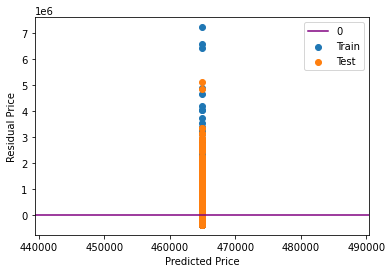

QQ Plot of residuals:


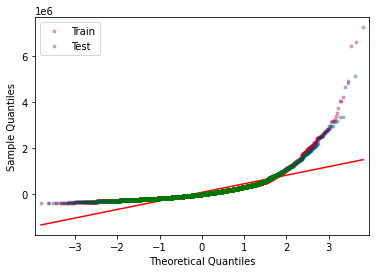

In [480]:
evaluate(y_train, y_test, baseline_train_pred, baseline_test_pred)

This very simple model will predict the average of the training data set prices and will not utilize any independent variable. This will result in the residuals being the same. As you can see the training and test residuals are almost directly over laid on one another. Which is predicatble based on the paramaters of our current model. This is not a practical model for the scope of our project.

### First model

In [481]:
def smols(X,y,cols=None):
    '''
    Uses Linear Regression to find a best fit given desired features.
    Arguments:
    X - dataframe
        Input features and values
    y - array-like
        Output values
    cols=None - list
        List of features to be included from the X dataframe
    Returns: OLS model. Use smols().summary() to view summary
    '''
    Xcol = X[cols]
    shmod = sm.OLS(endog=y, exog=sm.add_constant(Xcol)).fit()
    return shmod

In [482]:
def linpreds(X_tr_scaled, y_tr, X_te_scaled):
    '''
    Uses Linear Regression to generate output predictions given training and test inputs.
    Arguments:
    X_tr_scaled - dataframe
        Input variables and values for the training set
    y_tr - array-like
        Actual values for output variable, for the training set
    X_te_scaled - dataframe
        Input variables and values for the test set
    Returns:
    Output (y) prediction arrays:
        train, test
    '''
    lr = LinearRegression()
    lr.fit(X_tr_scaled, y_tr)
    return lr.predict(X_tr_scaled), lr.predict(X_te_scaled)

In [546]:
cols1 = ['sqft_living_log']
smols(X_train,y_train,cols).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:06:34   Log-Likelihood:                -6706.0
No. Observations:               14350   AIC:                         1.342e+04
Df Residuals:                   14348   BIC:                         1.343e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.6707      0.058    115.583      0.000       6.558       6.784
sqft_living_log     0.8444      0.008    110.699      0.000       0.829       0.859
==============================================================================
Omnibus:                       70.354   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.096
Skew:                           0.136   Prob(JB):                     4.44e-15
Kurtosis:                       2.810   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train R2 score: 0.4267810471582947 
Test R2 score: 0.41347982037291753 
<><><><><>
Train RMSE: $281,242.40 
Test RMSE: $276,197.44 
<><><><><>
Train MAE: $167,545.36 
Test MAE: $171,131.23 

Scatter of residuals:


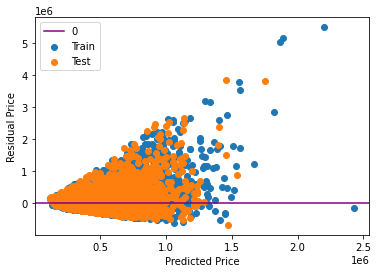

QQ Plot of residuals:


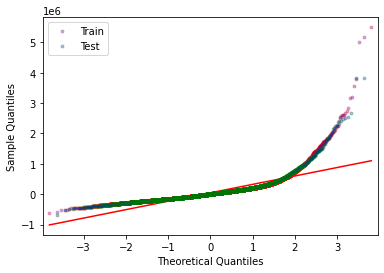

In [548]:
Xftr1, Xfte1 = X_train[cols1], X_test[cols1]
trp1, tep1 = linpreds(Xftr1, y_train, Xfte1)
evaluate(y_train, y_test, trp1, tep1)

This is a very simple, substandard simple linear regression model for the space in a home vs the price of the home. This was the strongest correlation we found in our initial analysis.

This model is better than the baseline model, because it is taking one independent variable into the model compared to none in our base line model. The model is accounting for 46.1% variance in the model. The p-value is less than our alpha of 0.05 which implies significance.

The residuals appear heteroskedastic, and the QQ plot would suggest they are not normally distributed. Therefore, this model violates some assumptions of linear regression.

### Modeling Iterations

Now that we have a 'better' model, we can start to add extra features that seem to add predictive value to the model. These are given by the correlation values generated earlier. We'll start with bathrooms and then add the grade categories. Sqft_above is ignored for now because it has some multicollinearity (independence) issues with sqft_living_log.

In [549]:
cols2 = ['sqft_living_log','bathrooms']
smols(X_train_scaled,y_train,\
      cols=cols2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     6216.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:09:43   Log-Likelihood:                -6658.2
No. Observations:               14350   AIC:                         1.332e+04
Df Residuals:                   14347   BIC:                         1.335e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.0496      0.003   4061.690      0.000      13.043      13.056
sqft_living_log     0.3198      0.005     64.471      0.000       0.310       0.330
bathrooms           0.0486      0.005      9.793      0.000       0.039       0.058
==============================================================================
Omnibus:                       79.036   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.952
Skew:                           0.144   Prob(JB):                     8.74e-17
Kurtosis:                       2.799   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train R2 score: 0.4404495240933993 
Test R2 score: 0.423138829536289 
<><><><><>
Train RMSE: $277,869.04 
Test RMSE: $273,913.75 
<><><><><>
Train MAE: $166,728.90 
Test MAE: $170,645.43 

Scatter of residuals:


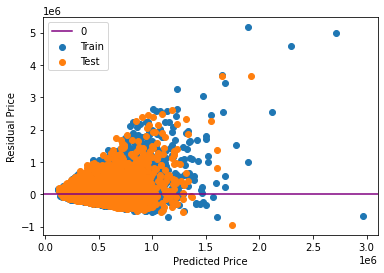

QQ Plot of residuals:


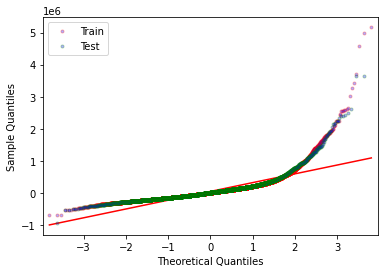

In [550]:
Xftr2, Xfte2 = X_train[cols2], X_test[cols2]
trp2, tep2 = linpreds(Xftr2, y_train, Xfte2)
evaluate(y_train, y_test, trp2, tep2)

Adding bathrooms seems to help only slightly, as its coefficiant is much lower than sqft_living_log.

In [551]:
cols3 = ['sqft_living_log','bathrooms','Above Average Grade', 
            'Excellent Grade', 'Low Grade']
smols(X_train_scaled,y_train,\
      cols=cols3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     3275.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:11:00   Log-Likelihood:                -5671.4
No. Observations:               14350   AIC:                         1.135e+04
Df Residuals:                   14344   BIC:                         1.140e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.0496      0.003   4350.387      0.000      13.044      13.055
sqft_living_log         0.2223      0.005     43.291      0.000       0.212       0.232
bathrooms              -0.0013      0.005     -0.273      0.785      -0.011       0.008
Above Average Grade     0.1106      0.004     29.535      0.000       0.103       0.118
Excellent Grade         0.1725      0.004     43.981      0.000       0.165       0.180
Low Grade              -0.0400      0.003    -11.800      0.000      -0.047      -0.033
==============================================================================
Omnibus:                       59.299   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.115
Skew:                           0.147   Prob(JB):                     1.46e-13
Kurtosis:                       2.891   Cond. No.                         3.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train R2 score: 0.5063510665460886 
Test R2 score: 0.5060448815541274 
<><><><><>
Train RMSE: $260,993.46 
Test RMSE: $253,467.29 
<><><><><>
Train MAE: $156,449.41 
Test MAE: $158,899.55 

Scatter of residuals:


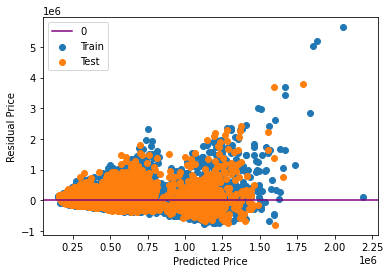

QQ Plot of residuals:


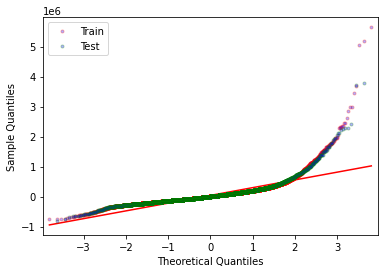

In [552]:
Xftr3, Xfte3 = X_train[cols3], X_test[cols3]
trp3, tep3 = linpreds(Xftr3, y_train, Xfte3)
evaluate(y_train, y_test, trp3, tep3)

Adding grade seems to have helped a fair bit, given that the r squred value has risen to 53.3% prediction in variance. Each of the pvalues is lower than alpha implying significance, except bathrooms, which is super high at 78.5%. This is surprising, given how strongly it alone is correlated with price. The top predictors are 'sqft_living_log' and 'Excellent Grade', which makes sense. Bigger homes in better quality should mean higher sale prices. Our condition number is low, meaning there are minimal issues with multicollinearity.

## Stepwise function

To find the best combination of features that result in the lowest error in predicted price, we built a forward-backward optimization function.

In the forward step, it takes a model with certain included features, and generates a Series of R2 values associated with models (using training data) that include the initial features and one extra feature among those remaining. The best R2 value (for test data) for the new model is compared to the R2 value (for test data) for the initial model. If it is higher, the new feature is added to the included features for the next step and next iteration.

In the backward step, after adding each new variable to the included-feature model, the algorithm will generate a Series of RMSE values associated with models that remove one variable from the included-feature model. In that list, the lowest RMSE is compared to the RMSE of the full included-feature model, and if it is lower, that feature is removed from the included-feature model for the next iteration. 

The algorithm proceeds in an iterative fashion until no features are added or removed.

In [486]:
def stepwise_selection(X_tr, y_tr, X_te=None, y_te=None,
                       initial_list=[], no_use=[], 
                       verbose=True):
    """
    Perform a forward-backward feature selection 
    based on R2 (forward) and RMSE (backward) from sklearn
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        X_tr - pandas.DataFrame with training candidate features
        y_tr - list-like with the training target
        X_te - pandas.DataFrame with test candidate features
        y_te - list-like with the test target
        initial_list - list of features to start with (column names of X_tr)
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(set(initial_list))
    while True:
        changed=False
        # forward step with R2
        # add feature if the resulting test R2 >= previous test R2
        on_hold = []
        excluded = list(set(X_tr.columns)-set(no_use)-set(included)-set(on_hold))
        new_r2 = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            trpred, tepred = linpreds(X_tr[included+[new_column]], y_tr, 
                                      X_te[included+[new_column]])
            new_r2[new_column] = r2_score(y_te, tepred)
        best_r2 = new_r2.max()
        if best_r2 > r2_score(y_te, tepred):
            best_feature = new_r2.idxmax()
            included.append(best_feature)
            try:
                on_hold.pop()
            except:
                pass
            changed=True
            if verbose:
                print('Add  {:30} with r2: {:.6}'.format(best_feature, best_r2))

        # backward step with RMSE
        trpred, tepred = linpreds(X_tr[included], y_tr, X_te[included])
        y_te_unl, tepred_unl = np.exp(y_te), np.exp(tepred)
        rmse_pre = mean_squared_error(y_te_unl, tepred_unl, squared=False)
        print('Before removal RMSE: {:.2f}'.format(rmse_pre))
        rmses = pd.Series(index=included, dtype='float64')
        for column in included:
            trpred, tepred = linpreds(X_tr[list(set(included)-set(column))], y_tr, 
                                      X_te[list(set(included)-set(column))])
            y_te_unl, tepred_unl = np.exp(y_te), np.exp(tepred)
            rmses[column] = mean_squared_error(y_te_unl, tepred_unl, squared=False)
        lowest_rmse = rmses.min()
        if lowest_rmse < rmse_pre:
            changed=True
            bad_feature = rmses.idxmin()
            on_hold.append(bad_feature)
            included.remove(bad_feature)
            if verbose:
                print('Drop {:30} with RMSE {:.2f}'.format(bad_feature, lowest_rmse))
        else:
            if verbose:
                print('Keep {:30} with RMSE {:.2f}'.format(best_feature, lowest_rmse))
        if not changed:
            break
    return included

In [494]:
stepwise_selection(X_train_scaled, y_train, X_test_scaled, y_test,  \
                   initial_list=['sqft_living_log', 'Low Grade',
                                 'Excellent Grade','Above Average Grade'], 
                   no_use=['sqft_living','sqft_lot','sqft_above']) # don't include non-log features

Add  has_basement                   with r2: 0.532676
Before removal RMSE: 250191.36
Keep has_basement                   with RMSE 250191.36
Add  Good Condition                 with r2: 0.538999
Before removal RMSE: 247767.63
Keep Good Condition                 with RMSE 247767.63
Add  sqft_lot_log                   with r2: 0.543615
Before removal RMSE: 245996.06
Keep sqft_lot_log                   with RMSE 245996.06
Before removal RMSE: 245996.06
Keep sqft_lot_log                   with RMSE 245996.06


['Excellent Grade',
 'Low Grade',
 'Above Average Grade',
 'sqft_living_log',
 'has_basement',
 'Good Condition',
 'sqft_lot_log']

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [495]:
relcol =['Excellent Grade',
 'Low Grade',
 'Above Average Grade',
 'sqft_living_log',
 'has_basement',
 'Good Condition',
 'sqft_lot_log']
smols(X_train_scaled, y_train, cols=relcol).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     2551.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:54:30   Log-Likelihood:                -5333.3
No. Observations:               14350   AIC:                         1.068e+04
Df Residuals:                   14342   BIC:                         1.074e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.0496      0.003   4453.769      0.000      13.044      13.055
Excellent Grade         0.1895      0.004     49.331      0.000       0.182       0.197
Low Grade              -0.0363      0.003    -10.902      0.000      -0.043      -0.030
Above Average Grade     0.1210      0.004     32.688      0.000       0.114       0.128
sqft_living_log         0.2197      0.005     47.716      0.000       0.211       0.229
has_basement            0.0396      0.003     12.613      0.000       0.033       0.046
Good Condition          0.0532      0.003     17.491      0.000       0.047       0.059
sqft_lot_log           -0.0399      0.003    -12.257      0.000      -0.046      -0.033
==============================================================================
Omnibus:                       32.615   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.777
Skew:                           0.117   Prob(JB):                     7.63e-08
Kurtosis:                       3.017   Cond. No.                         2.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train R2 score: 0.534764294824601 
Test R2 score: 0.5347354630234102 
<><><><><>
Train RMSE: $253,371.08 
Test RMSE: $245,996.06 
<><><><><>
Train MAE: $151,677.31 
Test MAE: $152,785.76 

Scatter of residuals:


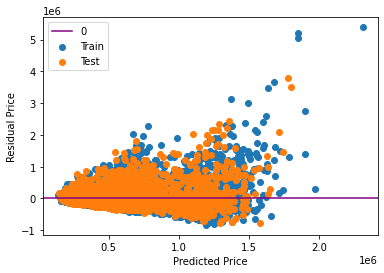

QQ Plot of residuals:


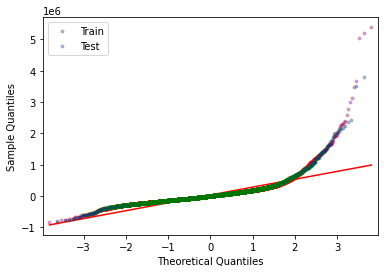

In [496]:
Xftr, Xfte = X_train_scaled[relcol], X_test_scaled[relcol]
trp, tep = linpreds(Xftr, y_train, Xfte)
evaluate(y_train, y_test, trp, tep)

Our final model resulted in a $152,7285.76 average variation from observed sales prices and ended with a R squared value of .555 meaning our model accounts for a 55.5\% variance in sales price. All of the features have a pvalue of less than 0.05, which implies all features are significant to the model. Our condition number is less than a 5, meaning there is little multicollinearity issues. The scatter plot of the residuals does display some heteroskedasticity. Based on the QQ plot, the residuals are slightly skewed to the right. Our model does therefore violate the assumptions of linear regression, but only slightly, and maybe not enough to make it not valuable. It is interesting to note that none of the engineered features and the number of bathrooms made it into the final model.

## Conclusion

We recommend Mom & Pop Realty use the size of the house and property, grade and condition of the house, and whether the house has a basement to understand the potential sale price of the a clients home. The strongest predictors are House Square Footage, where a 1% increase in Home square footage translates to an increase in 0.22% sale price. The next strongest predictor is the grade of the house, specifically, where the house has an excellent grade. Homes with an excellent grade has a 20.1% higher sales price than that of a home with an average grade. We understand this model is incomplete and the level of bias in the model reduces the overall effectiveness.

Especially given the average error is ~$\150,000, the price of some homes in the dataset, we would not recommend Mom & Pop Realty use the model to give an accurate numerical estimate for the sale price of a home. Rather, it is effective as a view into what features are important determinants of sale price.

Critically, our final model does not include location data. Adding those features to the model may help the model's bias, heteroskedasticity issues, and overall predictive power.